In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Attention
from keras.layers import Lambda

In [2]:
def get_data_frame():
    current_folder = os.getcwd()
    file_path = os.path.join(current_folder,'..' ,'resource', 'RSMC_Best_Track_Data.csv')
    df = pd.read_csv(file_path)

    # ---------------------------

    direction_30_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8}
    df['Direction of the longest radius of 30kt winds or greater'] = df[
        'Direction of the longest radius of 30kt winds or greater'].map(direction_30_mapping)

    direction_50_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 6, 'Southwest (SW)': 8,
                            'No direction (Longest radius of 50kt winds is 0)': 9}
    df['Direction of the longest radius of 50kt winds or greater'] = df[
        'Direction of the longest radius of 50kt winds or greater'].map(direction_50_mapping)

    indicator_mapping = {'#': 1, ' ': 0}
    df['Indicator of landfall or passage'] = df['Indicator of landfall or passage'].map(indicator_mapping)

    # ----------------------

    df = df.drop(['International number ID', 'Name of the storm', 'Grade'], axis=1)
    columns_to_check = [
        'Direction of the longest radius of 50kt winds or greater',
        'The longest radius of 50kt winds or greater',
        'The shortest radius of 50kt winds or greater',
        'Direction of the longest radius of 30kt winds or greater',
        'The longest radius of 30kt winds or greater',
        'The shortest radius of 30kt winds or greater'
    ]
    df = df.dropna(subset=columns_to_check)

    # -----------------------

    one_hot_encoded = pd.get_dummies(df['Direction of the longest radius of 50kt winds or greater'],
                                     prefix='Direction of the longest radius of 50kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded], axis=1)

    one_hot_encoded2 = pd.get_dummies(df['Direction of the longest radius of 30kt winds or greater'],
                                      prefix='Direction of the longest radius of 30kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded2], axis=1)
    df = df.drop(['Direction of the longest radius of 50kt winds or greater',
                  'Direction of the longest radius of 30kt winds or greater'], axis=1)

    # ----------------------

    df['Time of analysis'] = pd.to_datetime(df['Time of analysis'])
    df['Time of analysis'] = df['Time of analysis'].apply(lambda x: x.timestamp())

    # -----------------------
    return df

In [3]:
def min_max_scaler():
    
    df = get_data_frame()
    
    columns_to_normalize = df.columns[:]

    # 实例化 MinMaxScaler
    scaler = MinMaxScaler()

    # 对选择的列进行归一化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # 打印处理后的新 DataFrame 的信息
    #df.tail()

    return df

In [4]:
def split_data():
    df = min_max_scaler()
    split_index = int(0.7 * len(df))

    # 分割DataFrame
    train_set = df.iloc[:split_index, :]
    test_set = df.iloc[split_index:, :]

    train_x = train_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    train_y = train_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    test_x = test_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    test_y = test_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    # 给训练集的标签打上时间序列
    first_column = train_x.iloc[:, 0]
    train_y.insert(0, 'Time of analysis', first_column)
    

    return train_x, train_y, test_x, test_y


In [5]:
df = min_max_scaler()
x_train, y_train, text_x, test_y = split_data()
y_train.head()

,Time of analysis,Latitude of the center,Longitude of the center
25272,0.000000,0.084536,0.722877
25273,0.000015,0.094845,0.715802
25274,0.000030,0.105155,0.707547
25275,0.000044,0.113402,0.699292
25276,0.000059,0.119588,0.689858


In [6]:
test_head_y = test_y.loc[text_x.index[-20:-15]]

test_head_x = text_x.loc[text_x.index[-20:-15]]

test_tail_y = test_y.loc[text_x.index[-15:]]

test_tail_x = text_x.loc[text_x.index[-15:]]

In [198]:
verbose, epochs, batch_size = 1, 20, 50

# Assuming x_train and y_train have shapes: (samples, features) for both x_train and y_train
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]

# reshape output into [samples, features]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features_x, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs_x))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))  # Adjust the number of units to match the number of features in the output
model.compile(loss='mae', optimizer='adam')

# fit network
model.fit(x_train.values, y_train_reshaped, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20
383/383 [==============================] - 5s 8ms/step - loss: 0.1157
Epoch 2/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0904
Epoch 3/20
383/383 [==============================] - 3s 9ms/step - loss: 0.0880
Epoch 4/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0867
Epoch 5/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0861
Epoch 6/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0852
Epoch 7/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0847
Epoch 8/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0841
Epoch 9/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0839
Epoch 10/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0833
Epoch 11/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0828
Epoch 12/20
383/383 [==============================] - 3s 8ms/step - loss: 0.0825
Epoch 13/20
383/383 [====

In [12]:
test_head_y = test_y.loc[text_x.index[-1000:-995]]

test_head_x = text_x.loc[text_x.index[-1000:-995]]

test_tail_y = test_y.loc[text_x.index[-995:-990]]

test_tail_x = text_x.loc[text_x.index[-995:-990]]

In [6]:
test_head_y = test_y.loc[text_x.index[-20:-15]]

test_head_x = text_x.loc[text_x.index[-20:-15]]

test_tail_y = test_y.loc[text_x.index[-15:]]

test_tail_x = text_x.loc[text_x.index[-15:]]

In [11]:
test_head_y = test_y.loc[text_x.index[-5:]]

test_head_x = text_x.loc[text_x.index[-5:]]

test_tail_y = test_y.loc[text_x.index[-5:]]

test_tail_x = text_x.loc[text_x.index[-5:]]

In [7]:
model_pre = keras.models.load_model(r'C:\CODE\tropical_cyclone_prediction\model\CNN-LSTM-20-50.keras')

In [8]:
testPredict = model.predict(test_head_x)

#test_head
plt.plot(test_head_y['Longitude of the center'], test_head_y['Latitude of the center'], color='blue', marker='o')
#test_tail
plt.plot(test_tail_y['Longitude of the center'], test_tail_y['Latitude of the center'], color = 'green', marker='o')
#predict
plt.plot(testPredict[:, 2], testPredict[:, 1], label='numpy_array', color='red', marker='o')



# 设置图表标题和轴标签
plt.title('Track Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图表
plt.show()

NameError: name 'model' is not defined

In [9]:
current_folder = os.getcwd()

file_path = os.path.join(current_folder,'..' ,'model')

model.save(file_path + '\\CNN-LSTM-20-50.keras')

NameError: name 'model' is not defined

In [65]:
model_pre = keras.models.load_model(r'C:\CODE\tropical_cyclone_prediction\model\CNN-LSTM-20-200.keras')

1/1 [==============================] - 0s 24ms/step


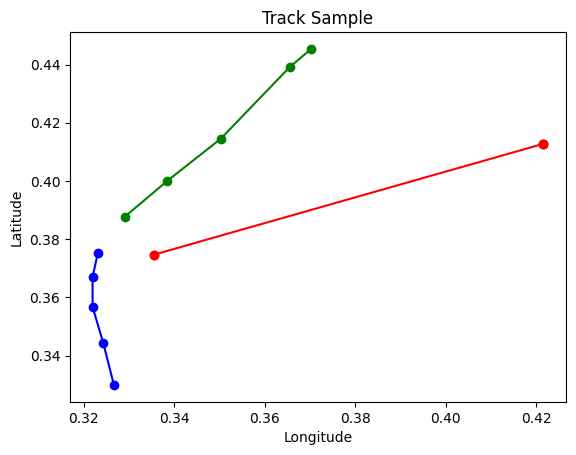

In [13]:
testPredict = model_pre.predict(test_head_x)

#test_head
plt.plot(test_head_y['Longitude of the center'], test_head_y['Latitude of the center'], color='blue', marker='o')
#test_tail
plt.plot(test_tail_y['Longitude of the center'], test_tail_y['Latitude of the center'], color = 'green', marker='o')
#predict
plt.plot(testPredict[:, 2], testPredict[:, 1], label='numpy_array', color='red', marker='o')



# 设置图表标题和轴标签
plt.title('Track Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图表
plt.show()

In [219]:
test_head_x.head()

,Time of analysis,Central pressure,Maximum sustained wind speed,The longest radius of 50kt winds or greater,The shortest radius of 50kt winds or greater,The longest radius of 30kt winds or greater,The shortest radius of 30kt winds or greater,Indicator of landfall or passage,Direction of the longest radius of 50kt winds or greater_1.0,Direction of the longest radius of 50kt winds or greater_2.0,...,Direction of the longest radius of 50kt winds or greater_8.0,Direction of the longest radius of 50kt winds or greater_9.0,Direction of the longest radius of 30kt winds or greater_1.0,Direction of the longest radius of 30kt winds or greater_2.0,Direction of the longest radius of 30kt winds or greater_3.0,Direction of the longest radius of 30kt winds or greater_4.0,Direction of the longest radius of 30kt winds or greater_5.0,Direction of the longest radius of 30kt winds or greater_6.0,Direction of the longest radius of 30kt winds or greater_8.0,Direction of the longest radius of 30kt winds or greater_9.0
68712,0.999719,0.871429,0.095238,0.000000,0.00,0.228916,0.25,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68713,0.999733,0.857143,0.142857,0.000000,0.00,0.228916,0.25,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68714,0.999748,0.821429,0.190476,0.184615,0.24,0.228916,0.25,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68715,0.999763,0.785714,0.238095,0.184615,0.24,0.228916,0.25,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68716,0.999778,0.714286,0.333333,0.184615,0.24,0.265060,0.30,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [221]:
test_tail_y

,Latitude of the center,Longitude of the center
68717,0.315464,0.387972
68718,0.323711,0.387972
68719,0.336082,0.384434
68720,0.342268,0.382075
68721,0.350515,0.382075
68722,0.358763,0.382075
68723,0.379381,0.385613
68724,0.395876,0.389151
68725,0.418557,0.396226
68726,0.443299,0.403302
